## Calculating displacement due to faulting

This notebook will calculate _displacement_ at specified points due to slip on a fault. 

In [1]:
# Import libraries
import pandas as pd
import numpy as np # Numerical analysis
import gmsh # Creation of fault models
import meshio # Interaction between fault model files and Python
import matplotlib.pyplot as plt # Visualize 
from pyproj import Proj
import pyproj
import h5py
%matplotlib widget

In [2]:
# Define some basic coordinate transformation functions
GEOID = pyproj.Geod(ellps="WGS84")
KM2M = 1.0e3
RADIUS_EARTH = np.float64((GEOID.a + GEOID.b) / 2)

def sph2cart(lon, lat, radius):
    lon_rad = np.deg2rad(lon)
    lat_rad = np.deg2rad(lat)
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)
    return x, y, z

def cart2sph(x, y, z):
    azimuth = np.arctan2(y, x)
    elevation = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    return azimuth, elevation, r

def wrap2360(lon):
    lon[np.where(lon < 0.0)] += 360.0
    return lon

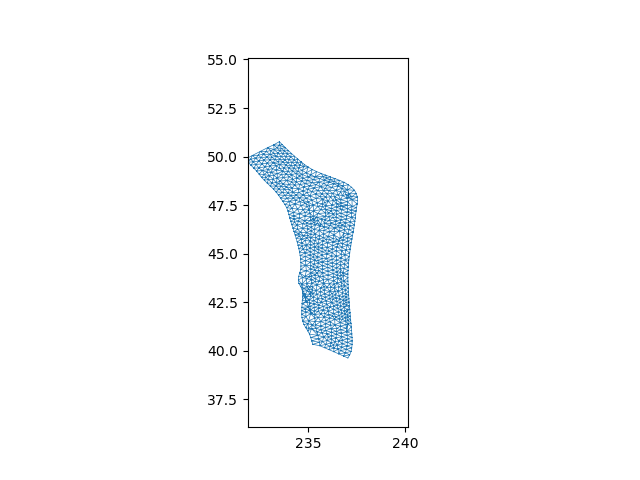

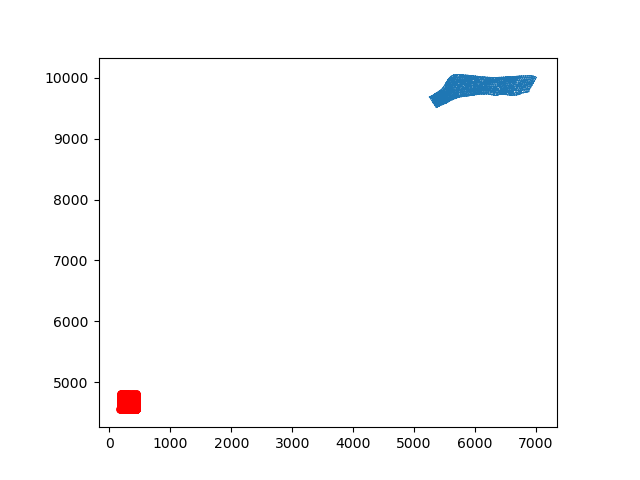

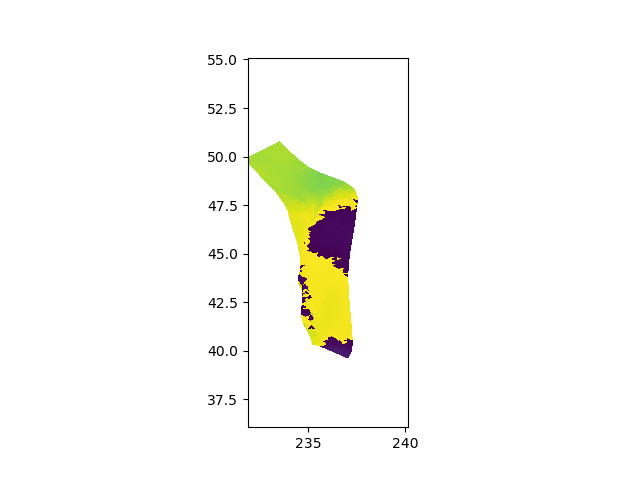

In [3]:
# Read in source fault
filename = "cascadia.msh"
# filename = "japan.msh"
mesh = dict()
meshobj = meshio.read(filename)
mesh["file_name"] = filename
mesh["points"] = meshobj.points
mesh["verts"] = meshio.CellBlock("triangle", meshobj.get_cells_type("triangle")).data
ntri = len(mesh["verts"])

# Expand mesh coordinates
mesh["lon1"] = mesh["points"][mesh["verts"][:, 0], 0]
mesh["lon2"] = mesh["points"][mesh["verts"][:, 1], 0]
mesh["lon3"] = mesh["points"][mesh["verts"][:, 2], 0]
mesh["lat1"] = mesh["points"][mesh["verts"][:, 0], 1]
mesh["lat2"] = mesh["points"][mesh["verts"][:, 1], 1]
mesh["lat3"] = mesh["points"][mesh["verts"][:, 2], 1]
mesh["dep1"] = mesh["points"][mesh["verts"][:, 0], 2]
mesh["dep2"] = mesh["points"][mesh["verts"][:, 1], 2]
mesh["dep3"] = mesh["points"][mesh["verts"][:, 2], 2]
mesh["centroids"] = np.mean(mesh["points"][mesh["verts"], :], axis=1)

# Cross products for orientations
tri_leg1 = np.transpose([np.deg2rad(mesh["lon2"] - mesh["lon1"]), np.deg2rad(mesh["lat2"] - mesh["lat1"]), (1 + KM2M * mesh["dep2"] / RADIUS_EARTH) - (1 + KM2M * mesh["dep1"] / RADIUS_EARTH)])
tri_leg2 = np.transpose([np.deg2rad(mesh["lon3"] - mesh["lon1"]), np.deg2rad(mesh["lat3"] - mesh["lat1"]), (1 + KM2M * mesh["dep3"] / RADIUS_EARTH) - (1 + KM2M * mesh["dep1"] / RADIUS_EARTH)])
mesh["nv"] = np.cross(tri_leg1, tri_leg2)
azimuth, elevation, r = cart2sph(mesh["nv"][:, 0], mesh["nv"][:, 1], mesh["nv"][:, 2])
mesh["strike"] = wrap2360(-np.rad2deg(azimuth))
mesh["dip"] = 90 - np.rad2deg(elevation)
mesh["dip_flag"] = mesh["dip"] != 90

# Set up grid where vertical displacement will be calculated

# Cascadia range
# xs = np.linspace(237, 240, 100)
# ys = np.linspace(40, 50, 100)

# Hokkaido range
xs = np.linspace(143, 146.5, 100)
ys = np.linspace(41, 43.5, 100)

# Reshape grid
obsx, obsy = np.meshgrid(xs, ys)
pts = np.array([obsx, obsy, 0 * obsy]).reshape((3, -1)).T.copy()

# Convert the fault and grid coordinates to Cartesian

# Set up transformation
lon_corr = 1
# Check longitude convention of mesh
if np.max(xs) > 180:
    lon_corr = 0

utmzone=int(32700-(np.sign(np.mean(ys))+1)/2 * 100+np.floor((lon_corr*180 + np.mean(xs))/6) + 1)
target_crs = 'epsg:'+str(utmzone) # Coordinate system of the file
source_crs = 'epsg:4326' # Global lat-lon coordinate system
latlon_to_utm = pyproj.Transformer.from_crs(source_crs, target_crs)

# Convert coordinates
faultxy = np.array(latlon_to_utm.transform(mesh["points"][:, 1], mesh["points"][:, 0])).T/1e3
gridxy = np.array(latlon_to_utm.transform(pts[:, 1], pts[:, 0])).T/1e3 

cart_fault_pts = np.zeros_like(mesh["points"])
cart_fault_pts[:, 0:2] = faultxy
cart_fault_pts[:, 2] = mesh["points"][:, 2]
cart_grid_pts = np.zeros_like(pts)
cart_grid_pts[:, 0:2] = gridxy
cart_grid_pts[:, 2] = pts[:, 2]

# Plot the source fault

# Setting up axis limits
xmin = np.mean(mesh["points"][:, 0]) - 3*np.std(mesh["points"][:, 0])
xmax = np.mean(mesh["points"][:, 0]) + 3*np.std(mesh["points"][:, 0])
ymin = np.mean(mesh["points"][:, 1]) - 3*np.std(mesh["points"][:, 1])
ymax = np.mean(mesh["points"][:, 1]) + 3*np.std(mesh["points"][:, 1])
# Read in coastline file
coast = pd.read_csv("coastline.csv")
# Define the figure and its axis
fig, ax = plt.subplots()
# Draw the fault
ax.triplot(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], linewidth=0.5)
# Add grid points
ax.plot(pts[:, 0], pts[:, 1], '.r')
# Add coastline
ax.plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
plt.show()

# Make another plot, showing fault and grid in Cartesian coordinates
fig, ax = plt.subplots()
ax.triplot(cart_fault_pts[:,0], cart_fault_pts[:, 1], mesh["verts"], linewidth=0.5)
ax.plot(cart_grid_pts[:, 0], cart_grid_pts[:, 1], '.r')
ax.set(aspect="equal")
plt.show()

# Show elements colored by strike
fig, ax = plt.subplots()
# Draw the fault
ax.tripcolor(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], facecolors=mesh["strike"])
# Add coastline
ax.plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
plt.show()


In [5]:
# Calculate the mathematical relationship between unit fault slip and displacement
# This takes a bit of time, but it only needs to be done once if your fault and grid don't change

import cutde.halfspace as cutde

disp_mat = cutde.disp_matrix(obs_pts=cart_grid_pts, tris=cart_fault_pts[mesh["verts"]], nu=0.25)
strain_mat = cutde.strain_matrix(obs_pts=cart_grid_pts, tris=cart_fault_pts[mesh["verts"]], nu=0.25)
# Write to HDF5 file
hf = h5py.File("disp_mat.h5", "w")
hf["disp_mat"] = disp_mat
hf.close()

In [5]:
# Read disp_mat from file

hf = h5py.File('disp_mat.h5', 'r')
disp_mat = np.array(hf["disp_mat"])
hf.close()

In [6]:
def radgauss(x0, y0, a, x, y, c):
# 
# RADGAUSS calculates a radial Gaussian distribution.
# 
# S = RADGAUSS(X0, Y0, A, X, Y, C) uses the formula:
# 
# S(Xi, Yi) = A exp(-Ri^2/2C^2)
# 
# to calculate the value S at point (Xi,Yi), which is located a distance
# Ri from point (X0,Y0), where the value is A.  C represents a Gaussian 
# curvature parameter: larger values of C produce more abrupt changes in
# value with distance.
# 
# X0, Y0 represent the x,y coordinates of the point of maximum magnitude A.
# X and Y are n x 1 arrays containing the x,y coordinates of all points at
# which the value S should be calculated.  C is a single value that applies
# to the entire calculation.
# 
# If C is a 2-element vector, the pattern will not be radial but elliptical,
# with the first element of C giving the curvature in the X direction and the
# second giving the curvature in Y:
# 
# S(Xi, Yi) = A exp( [ -(Xi-X0)^2 / 2C[0]^2 ] + [ -(Yi-Y0)^2 / 2C[1]^2] )
# 
# If C is a 3-element vector, an elliptical pattern will result, and the
# ellipse will be rotated C[2] degrees from the y-axis, where a positive 
# number gives a clockwise rotation.
    c = np.array(c)
    if np.size(c) == 1:
        r = np.sqrt((x-x0)**2+(y-y0)**2) # calculate distances
        s = a*np.exp(-r**2/(2*c**2)) # calculate Gaussian value
    elif np.size(c) == 2:
        s = a*np.exp((-(x-x0)**2./(2*c[0]**2)) + (-(y-y0)**2./(2*c[1]**2)))
    elif np.size(c) == 3:
        ang = np.deg2rad(c[2])
        rot = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]])
        coords = np.vstack((np.hstack((x.T, x0)), np.hstack((y.T, y0))))
        rcoords = rot.dot(coords)
        s = a*np.exp((-(rcoords[0, :-1]-rcoords[0, -1])**2/(2*c[0]**2)) + (-(rcoords[1, :-1]-rcoords[1, -1])**2/(2*c[1]**2)))

    return s  

In [ ]:
# Uniform fault slip distribution 
# slip = np.zeros_like(mesh["verts"])
# slip[:, 1] = 1 # Uniform dip-slip

# Radial slip distribution 

# Center coordinates of slip distribution
lon_center = 144 
lat_center = 42
# Stretch of slip gradient in x, y plus rotation angle
slip_shape = np.array([1, .5, 0])
s = radgauss(lon_center, lat_center, 1, mesh["centroids"][:, 0], mesh["centroids"][:, 1], slip_shape)

# Create full slip distribution, adding radial slip as dip-slip 
slip = np.vstack((np.zeros_like(s), s, np.zeros_like(s))).T

# Calculate predicted displacement at grid points that arises from fault slip
pred_disp = disp_mat.reshape((-1, 3*ntri)).dot(slip.reshape(3*ntri, 1))

plt.close('all')
# Visualize the slip and displacement pattern 
fig, ax = plt.subplots(1, 2)
fso = ax[0].tripcolor(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], facecolors=s)
# fig.colorbar(fso, ax=ax[0], orientation='horizontal')
ax[0].plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax[0].set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
ax[0].title.set_text("Fault slip")
# Show uplift (pred_disp[2::3])

# Get limits of displacement that is being plotted
plot_disp = pred_disp[2::3]
max_mag = np.max([np.max(plot_disp), np.abs(np.min(plot_disp))])
gdo = ax[1].pcolormesh(obsx, obsy, plot_disp.reshape(np.shape(obsx)), shading="auto", cmap="bwr", vmin=-max_mag, vmax=max_mag)
# Draw the fault
ax[1].triplot(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], linewidth=0.5, color='k')
# Add coastline
ax[1].plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax[1].set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
ax[1].yaxis.tick_right()
ax[1].title.set_text("Grid displacement")
plt.show()

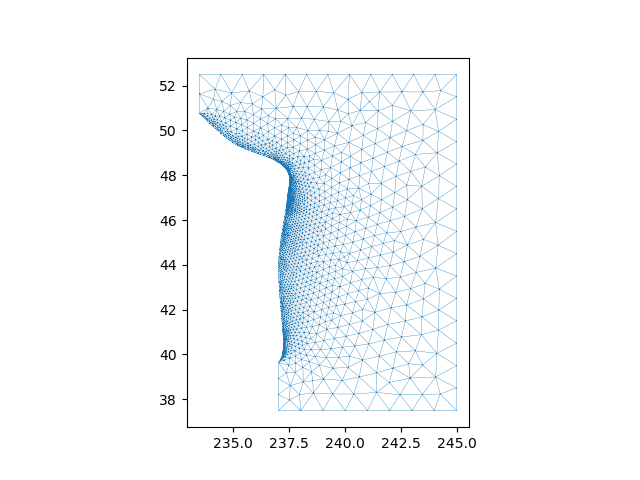

In [25]:
# Making a horizontal mesh

if gmsh.isInitialized() == 0:
        gmsh.initialize()
gmsh.option.setNumber("General.Verbosity", 0)    
gmsh.clear()

# Get bottom of subduction mesh
base_mesh = mesh["points"][np.where(mesh["points"][:, 2]==-50)[0], :]
ind = np.argsort(base_mesh[:, 1])
base_mesh = base_mesh[ind[::-1], :]
# Other perimeter control points
perim_points = np.array([[base_mesh[-1, 0], 37.5, -50], [245, 37.5, -50], [245, 52.5, -50], [base_mesh[0, 0], 52.5, -50]])

source_el_size = 1
# Define points
for i in range(len(base_mesh)):
    gmsh.model.geo.addPoint(base_mesh[i, 0], base_mesh[i, 1], base_mesh[i, 2], source_el_size, i)
for j in range(len(perim_points)):
    gmsh.model.geo.addPoint(perim_points[j, 0], perim_points[j, 1], perim_points[j, 2], source_el_size, i+j+1)
# Define lines
for k in range(i+j+1):
    gmsh.model.geo.addLine(k, k+1, k)
gmsh.model.geo.addLine(k+1, 0, k+1)
# Define curve loop
gmsh.model.geo.addCurveLoop(list(range(0, k+2)), 1)
# Surface
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.synchronize()
gmsh.write("horiz.geo_unrolled")
# Generate and write. Writing a file allows use of meshio, consistent with celeri codes
gmsh.model.mesh.generate(2)
gmsh.write("horiz.msh")
gmsh.finalize()

# Read and parse mesh
horiz = dict()
horizobj = meshio.read("horiz.msh")
horiz["points"] = horizobj.points
horiz["verts"] = meshio.CellBlock("triangle", horizobj.get_cells_type("triangle")).data
fig, ax = plt.subplots()
# Draw the fault
ax.triplot(horiz["points"][:, 0], horiz["points"][:, 1], horiz["verts"], linewidth=0.25)
ax.set_aspect("equal")
plt.show()


## Inversion of displacement data for slip on two meshes

In [ ]:
# Making a horizontal mesh

# Get bottom of subduction mesh

# Other perimeter control points

# Define a nominal element size
source_el_size = 1

# Use Gmsh to create the mesh
# Gmsh needs geometric elements defined in order of dimension: 
# Define points
# Define lines that connect those points
# Define perimeter as connections of lines
# Define surface from perimeter
# Mesh the surface into triangles

# Define points
for i in range(len(x)):
    gmsh.model.geo.addPoint(x, y, z, source_el_size, i)

# Define lines, each referencing the index of the 2 points it connects
for j in range(i+1):
    gmsh.model.geo.addLine(j, j+1, j)
gmsh.model.geo.addLine(j+1, 0, j+1)

# Define curve loop (perimeter), referencing the ordered indices of the lines
gmsh.model.geo.addCurveLoop(list(range(0, j+2)), 1)

# Define surface, referencing the index of the line loop
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.synchronize()
gmsh.write("mesh.geo_unrolled")
# Generate and write the mesh. Writing a file allows use of meshio
gmsh.model.mesh.generate(2)
gmsh.write("horiz.msh")
gmsh.finalize()

# Read and parse mesh
horiz = dict()
horizobj = meshio.read("horiz.msh")
horiz["points"] = horizobj.points
horiz["verts"] = meshio.CellBlock("triangle", horizobj.get_cells_type("triangle")).data
fig, ax = plt.subplots()
# Draw the fault
ax.triplot(horiz["points"][:, 0], horiz["points"][:, 1], horiz["verts"], linewidth=0.25)
ax.set_aspect("equal")
plt.show()

### Read postseismic GPS data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget
colnames = ['y', 'x', 'e', 'n', 'u']
gps = pd.read_table("/Users/jloveles/Documents/relax/examples/taiwan/gps/postseismic_neu_today_km.dat", sep='\s+', header=None, names=colnames)

# Place stations into single array
obsv = np.array([gps.x, gps.y, 0*gps.y]).reshape((3, -1)).T.copy()

plot_vectors = False
if plot_vectors:
    fig, ax = plt.subplots()
    ax.quiver(gps.x, gps.y, gps.e, gps.n)
    ax.axis("equal")
    plt.show()

### Concatenate meshes and calculate partial derivatives

In [ ]:
import addict 

# Define dictionary for both meshes
meshes = []
meshes.append(addict.Dict())

# Source fault mesh
meshes[0].coords = mesh["points"]
meshes[0].verts = mesh["verts"]

# Define horizontal mesh
meshes.append(addict.Dict())
meshes[1].coords = horiz["points"]
meshes[1].verts = horiz["verts"]
nsource_tri = np.shape(meshes[0].verts)[0]
nhoriz_tri = np.shape(meshes[1].verts)[0]
ntri = nsource_tri + nhoriz_tri

# Concatenate source and horizontal
source_tri_pts = meshes[0].coords[meshes[0].verts]
horiz_tri_pts = meshes[1].coords[meshes[1].verts]
all_tri_pts = np.concatenate((source_tri_pts, horiz_tri_pts), axis=0)

# Calculate element normals, strike and dip
meshes[0].normal_vector = np.cross(source_tri_pts[:, 1, :] - source_tri_pts[:, 0, :], source_tri_pts[:, 2, :] - source_tri_pts[:, 0, :])
meshes[1].normal_vector = np.cross(horiz_tri_pts[:, 1, :] - horiz_tri_pts[:, 0, :], horiz_tri_pts[:, 2, :] - horiz_tri_pts[:, 0, :])

# Calculate TDE partials for the subset array
disp_mat = cutde.disp_matrix(obs_pts=obsv, tris=all_tri_pts, nu=0.25)

### Calculate smoothing matrices and assemble

In [ ]:
def matrix_assembly(meshes, disp_mat, smoothing_weight):
    
    import celeri 
    import addict 
    
    # Get triangular smoothing matrix
    operators = addict.Dict()
    celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

    ndisp_comp = np.size(disp_mat, axis=1)
    nslip_comp = np.size(disp_mat, axis=3)

    if np.size(smoothing_weight) == 1:
        smoothing_weight = [smoothing_weight, smoothing_weight]

    nobs = ndisp_comp*np.size(disp_mat, axis=0)
    ntri = np.size(disp_mat, axis=2)
    nsource_tri = ntri - np.size(meshes[1].verts, axis=0)
    # nsource_tri = np.size(meshes[0].verts, axis=0)

    # Assemble matrices
    assembled_mat = np.zeros((nobs+nslip_comp*ntri, nslip_comp*ntri))
    # Insert elastic partials
    assembled_mat[0:nobs, :] = disp_mat.reshape((-1, nslip_comp*ntri))
    # Insert smoothing matrices
    source_row_start = nobs
    source_row_end = source_row_start + nslip_comp*nsource_tri
    horiz_row_start = source_row_end
    if nsource_tri != 0:
        assembled_mat[source_row_start:source_row_end, 0:nslip_comp*nsource_tri] = operators.smoothing_matrix[0].toarray()
    assembled_mat[source_row_end:, nslip_comp*nsource_tri:] = operators.smoothing_matrix[1].toarray()

    # Assemble weighting vector
    weights = np.ones((np.shape(assembled_mat)[0], 1))
    weights[source_row_start:source_row_end] = smoothing_weight[0]
    weights[horiz_row_start:] = smoothing_weight[1]

    return assembled_mat, weights

### Carry out inversion 

In [ ]:
# Some mesh counts
horiz_tri_pts = meshes[1].coords[meshes[1].verts]
n_horiz_tri = np.size(horiz_tri_pts, axis=0)
n_source_tri = 0
source_row_start = np.size(obsv)

# Allocate space for data vector
data_vector = np.zeros(source_row_start+3*n_horiz_tri)

# List of smoothing weights to test
smooths = [1e-6, 1e-2, 1e-1]

# Assemble with smoothing
assembled_mat, weights = matrix_assembly(meshes, disp_mat, smoothing_weight=smooths[1])

# Calculate model covariance
cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat) 

# Vector of displacements
disp_array = np.array([gps.e, gps.n, gps.u]).reshape((3, -1)).T.copy()
data_vector[0:source_row_start] = disp_array.flatten()
# Estimate slip using pre-calculated covariance
est_slip = cov @ assembled_mat.T * weights.T @ data_vector 
# Predict displacement at stations
pred_disp = disp_mat.reshape((-1, 3*n_horiz_tri)).dot(est_slip)